<a href="https://colab.research.google.com/github/Maximilian-MV/-/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B_%D0%BA%D0%BE%D0%BD%D1%82%D1%80%D0%BE%D0%BB%D1%8F_%D0%BA%D1%80%D1%83%D0%BF%D0%BD%D0%BE%D0%B3%D0%BE_%D1%80%D0%BE%D0%B3%D0%B0%D1%82%D0%BE%D0%B3%D0%BE_%D1%81%D0%BA%D0%BE%D1%82%D0%B0_%D1%81_%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%D0%BC_%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = '/content/drive/My Drive/Data_cow/object_image_cow'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/My Drive'


/content/drive/My Drive


### Визуализация нескольких изображений

визуализируем несколько учебных изображений, чтобы понять, как дополнить данные.



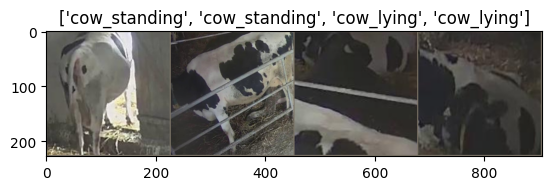

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Обучение модели
Далее реализована обучения модели. Здесь мы проиллюстрируем это:

Планирование скорости обучения
Сохранение лучшей модели
В следующем примере параметр scheduler - это объект LR scheduler из torch.optim.lr_scheduler.


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Визуализация предсказаний модели
Общая функция для отображения предсказаний для нескольких изображений





In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Тонкая настройка сети ConvNet
Загрузите предварительно обученную модель и сбросьте последний полностью подключенный слой.




In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model_ft.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
model_ft.fc.in_features

512

In [ ]:

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
for i in model_ft.parameters():
  print(i)

Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01]

### Обучение и оценка






In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3617 Acc: 0.8473
val Loss: 0.0024 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.2922 Acc: 0.8955
val Loss: 0.0242 Acc: 0.9959

Epoch 2/24
----------
train Loss: 0.2919 Acc: 0.9016
val Loss: 0.0009 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.2817 Acc: 0.9150
val Loss: 0.0119 Acc: 0.9918

Epoch 4/24
----------
train Loss: 0.1712 Acc: 0.9436
val Loss: 0.0068 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.2495 Acc: 0.9385
val Loss: 0.0042 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.2219 Acc: 0.9273
val Loss: 0.0021 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.2131 Acc: 0.9488
val Loss: 0.0027 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1487 Acc: 0.9518
val Loss: 0.0036 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1059 Acc: 0.9703
val Loss: 0.0026 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1375 Acc: 0.9641
val Loss: 0.0036 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1767 Acc: 0.9498
val Loss: 0.0047 Acc: 1.0000

Ep

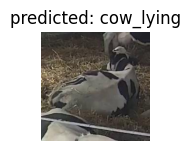

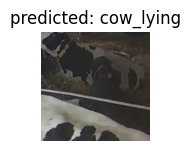

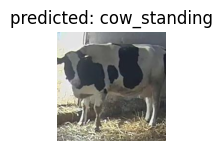

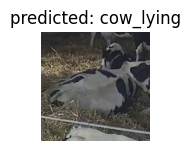

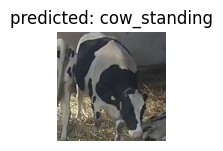

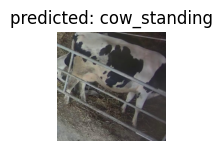

In [ ]:
visualize_model(model_ft)

## ConvNet

Здесь нам нужно заморозить всю сеть, кроме последнего слоя. Нам нужно установить requires_grad = False, чтобы заморозить параметры, чтобы градиенты не вычислялись в функции backward().





In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Обучение и оценка
На CPU это займет примерно половину времени по сравнению с предыдущим сценарием. Это ожидаемо, поскольку градиенты для большей части сети вычислять не нужно. Однако вычисление форварда все же необходимо.





In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5042 Acc: 0.7510
val Loss: 0.0680 Acc: 0.9796

Epoch 1/24
----------
train Loss: 0.4136 Acc: 0.8135
val Loss: 0.1304 Acc: 0.9551

Epoch 2/24
----------
train Loss: 0.5021 Acc: 0.8084
val Loss: 0.0272 Acc: 0.9959

Epoch 3/24
----------
train Loss: 0.3753 Acc: 0.8545
val Loss: 0.0305 Acc: 0.9878

Epoch 4/24
----------
train Loss: 0.3452 Acc: 0.8525
val Loss: 0.0195 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.3501 Acc: 0.8811
val Loss: 0.0246 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.3640 Acc: 0.8617
val Loss: 0.0241 Acc: 0.9959

Epoch 7/24
----------
train Loss: 0.2594 Acc: 0.8934
val Loss: 0.0197 Acc: 0.9959

Epoch 8/24
----------
train Loss: 0.2785 Acc: 0.8842
val Loss: 0.0216 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.2651 Acc: 0.9037
val Loss: 0.0218 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2883 Acc: 0.8730
val Loss: 0.0324 Acc: 0.9878

Epoch 11/24
----------
train Loss: 0.2686 Acc: 0.8945
val Loss: 0.0215 Acc: 0.9959

Ep

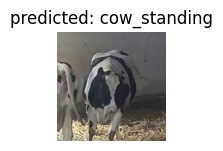

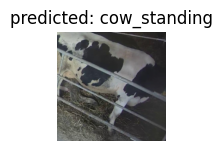

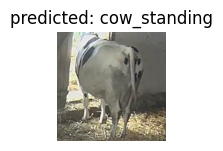

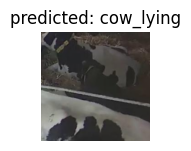

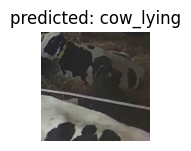

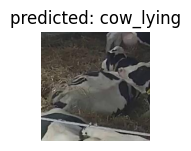

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Вывод изображений




In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        print(outputs)
        _, preds = torch.max(outputs, 1)
        s = torch.nn.Softmax(dim=0)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]} {s(outputs[0]).cpu().numpy()[preds]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [ ]:
!wget https://www.agroinvestor.ru/upload/iblock/8de/8de23dcf93a15ba49ae204f2498df956.jpg

--2023-12-01 12:27:10--  https://www.agroinvestor.ru/upload/iblock/8de/8de23dcf93a15ba49ae204f2498df956.jpg
Resolving www.agroinvestor.ru (www.agroinvestor.ru)... 77.223.109.220
Connecting to www.agroinvestor.ru (www.agroinvestor.ru)|77.223.109.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118941 (116K) [image/jpeg]
Saving to: ‘8de23dcf93a15ba49ae204f2498df956.jpg’

8de23dcf93a15ba49ae 100%[===================>] 116.15K   227KB/s    in 0.5s    

2023-12-01 12:27:11 (227 KB/s) - ‘8de23dcf93a15ba49ae204f2498df956.jpg’ saved [118941/118941]



tensor([[-3.8029,  2.9520]], device='cuda:0')


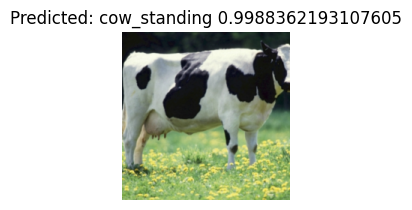

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='8de23dcf93a15ba49ae204f2498df956.jpg'
)

plt.ioff()
plt.show()

In [ ]:
!wget https://1korm.com/upload/iblock/e7f/9x6nm3lvr735ipwgonsrj04e6w31f8gw.jpg

--2023-12-01 12:27:12--  https://1korm.com/upload/iblock/e7f/9x6nm3lvr735ipwgonsrj04e6w31f8gw.jpg
Resolving 1korm.com (1korm.com)... 87.249.38.16, 2a03:6f00:6:1::57f9:2610
Connecting to 1korm.com (1korm.com)|87.249.38.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 526987 (515K) [image/jpeg]
Saving to: ‘9x6nm3lvr735ipwgonsrj04e6w31f8gw.jpg’

9x6nm3lvr735ipwgons 100%[===================>] 514.64K   631KB/s    in 0.8s    

2023-12-01 12:27:13 (631 KB/s) - ‘9x6nm3lvr735ipwgonsrj04e6w31f8gw.jpg’ saved [526987/526987]



In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/Data_cow/object_image_cow/third_cow_lying/01.jpg_cow_lying _1075_193.jpg'
)

plt.ioff()
plt.show()